**Before you dive into the implementations, I highly recommend first learning the heart of each concept —its core idea and where we use. You can explore this through YouTube tutorials, books, or online courses. This repository is meant to complement that knowledge by showing how to translate concepts into working code.**

#LDA Model Implementation, Interpretation, and Drawbacks

In this notebook, we implemented a Latent Dirichlet Allocation (LDA) model using Gensim. Below is an overview of our approach, how to interpret the model’s outputs, and some inherent limitations of LDA.


#Implementation Details

* **Data Preprocessing:**
  * We used spaCy to perform lemmatization and to filter tokens by part-of-speech (keeping only nouns, verbs, and adjectives). This helps in reducing noise and retaining words that carry meaningful information.
  * Additional cleaning steps (e.g., lowercasing, removal of punctuation and stopwords & filter out less and more frequent words) ensured that the corpus was consistent and focused on significant terms.

* **Dictionary and Corpus Creation:**

  A dictionary is built using gensim.corpora.Dictionary(processed_docs), which scans through the corpus and assigns a unique integer ID to each unique token.
  The Bag-of-Words (BOW) corpus is then created by converting each document into a list of (word_id, frequency) pairs. This numerical representation is necessary for the LDA algorithm to process the data.

* **Model Training:**
We trained the LDA model with parameters:

  * num_topics=20 (i.e., we aim to uncover 20 topics)

  * passes=20 (to allow the model to converge)

  * alpha='auto' and eta='auto' so that Gensim optimizes these priors based on the data

  * random_state=1 for reproducibility

* The model learns two main probability distributions:
  * Document-Topic Distribution (θ): Each document is represented as a mixture of topics.

  * Topic-Word Distribution (ϕ): Each topic is characterized by a probability distribution over words.

In [ ]:
# Step 0: Install required packages
!pip install gensim pyLDAvis spacy scikit-learn
!python -m spacy download en_core_web_sm


In [27]:
# Step 1: Import libraries
import re
import gensim
from gensim import corpora
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from sklearn.datasets import fetch_20newsgroups
import spacy
import pandas as pd

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
# download sample dataset
# Enable notebook display for pyLDAvis
pyLDAvis.enable_notebook()

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Load a subset of the 20 Newsgroups dataset (e.g., 1000 documents for speed)
data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes')).data[:1000]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
# Step 2: Preprocess the data using spaCy with lemmatization and POS filtering.
# We'll keep only nouns, verbs, and adjectives.

def spacy_preprocess(text):
    doc = nlp(text)
    # Allowed parts of speech
    allowed_pos = {'NOUN', 'VERB', 'ADJ'}
    tokens = [
        token.lemma_.lower()
        for token in doc
        if token.pos_ in allowed_pos and token.is_alpha and not token.is_stop and len(token) > 2
    ]
    return tokens

# Apply preprocessing to all documents
processed_docs = [spacy_preprocess(doc) for doc in data]


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
# Step 3: Create a dictionary and corpus from the processed documents.
dictionary = corpora.Dictionary(processed_docs)

# Filter out words that appear in less than 5 documents or more than 50% of documents
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Create the Bag-of-Words (BOW) corpus
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
# Use random_state=1 for reproducibility
# Set eta='auto' so that Gensim automatically optimizes the topic-word distribution
num_topics = 20

lda_model = gensim.models.LdaModel(corpus=corpus,
                                   id2word=dictionary,
                                   num_topics=num_topics,
                                   random_state=1,
                                   update_every=1,
                                   chunksize=100,
                                   passes=20,
                                   alpha='auto',
                                   eta='auto',
                                   per_word_topics=True)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
# Step 5: Explore the Topics
# Print each topic with its top 10 words
for idx, topic in lda_model.print_topics(num_words=10):
    print(f"Topic {idx}: {topic}\n")


Topic 0: 0.066*"new" + 0.051*"include" + 0.048*"set" + 0.038*"window" + 0.028*"application" + 0.028*"code" + 0.028*"start" + 0.021*"company" + 0.020*"standard" + 0.020*"allow"

Topic 1: 0.038*"time" + 0.033*"people" + 0.030*"year" + 0.025*"say" + 0.019*"read" + 0.017*"idea" + 0.017*"see" + 0.015*"power" + 0.015*"look" + 0.015*"give"

Topic 2: 0.051*"know" + 0.051*"think" + 0.029*"good" + 0.025*"way" + 0.022*"believe" + 0.021*"want" + 0.021*"question" + 0.020*"thing" + 0.018*"come" + 0.015*"case"

Topic 3: 0.113*"file" + 0.113*"program" + 0.101*"thank" + 0.048*"create" + 0.038*"software" + 0.032*"reply" + 0.029*"information" + 0.029*"need" + 0.028*"advance" + 0.027*"wonder"

Topic 4: 0.088*"go" + 0.085*"problem" + 0.059*"lot" + 0.049*"list" + 0.048*"sure" + 0.034*"lose" + 0.034*"change" + 0.031*"effect" + 0.029*"talk" + 0.025*"start"

Topic 5: 0.091*"system" + 0.071*"post" + 0.059*"drive" + 0.048*"try" + 0.042*"address" + 0.041*"article" + 0.040*"mail" + 0.037*"contact" + 0.036*"interes

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
# Step 6: Create a DataFrame showing each topic and its top words
topics_data = []
for topic_id, words in lda_model.show_topics(formatted=False, num_words=10):
    top_words = ", ".join([word for word, prob in words])
    topics_data.append({"Topic": topic_id, "Top Words": top_words})

df_topics = pd.DataFrame(topics_data)
df_topics


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic,Top Words
0,16,"display, cost, earth, fast, health, entire, ma..."
1,11,"card, speed, video, email, performance, clock,..."
2,17,"sell, machine, phone, encryption, technology, ..."
3,9,"win, page, year, today, research, reference, n..."
4,14,"child, kill, fire, bike, report, armenian, gun..."
5,18,"point, law, write, right, text, love, governme..."
6,0,"new, include, set, window, application, code, ..."
7,10,"use, work, help, bit, line, number, chip, call..."
8,1,"time, people, year, say, read, idea, see, powe..."
9,2,"know, think, good, way, believe, want, questio..."


In [ ]:
!pip install wordcloud

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


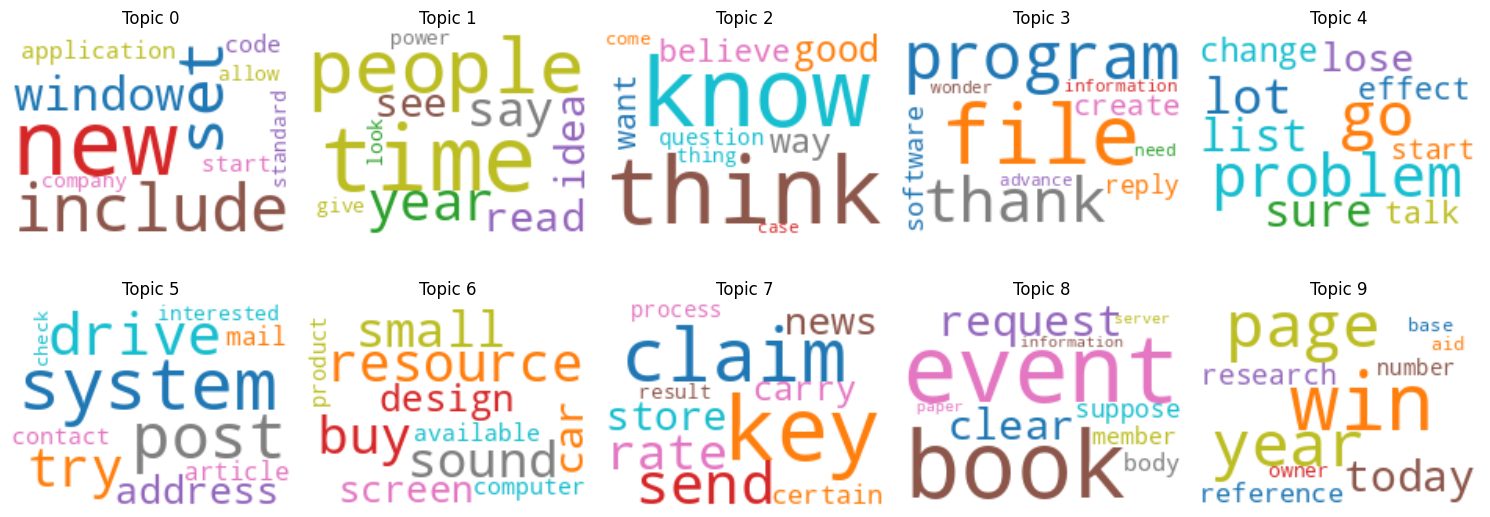

In [36]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Number of top words to display per topic
num_top_words = 10

# Create a grid with 2 rows and 5 columns (since we have 10 topics)
fig, axes = plt.subplots(2, 5, figsize=(15, 6), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    # Get top words and their weights for topic i
    topic_words = dict(lda_model.show_topic(i, num_top_words))

    # Generate a word cloud for this topic with smaller dimensions
    wc = WordCloud(width=180, height=130, background_color='white', colormap='tab10') \
             .generate_from_frequencies(topic_words)

    # Display the word cloud on the subplot
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f"Topic {i}", fontsize=12)

plt.tight_layout()
plt.show()


#Results Interpretation

  **Topic-Word Distributions:**

  For each topic, the model outputs a list of words with associated probabilities. For example, a topic with top words such as "technology", "computer", and "software" likely represents a tech-related theme.

  **Visualization:**
  
We use WordCloud to  generate word clouds for each topic. Word clouds help summarize each topic—larger words indicate higher weights.

  **DataFrame Summary:**

  We compile the top words for each topic into a DataFrame for easier review and further analysis.

#Drawbacks and Limitations

  **Bag-of-Words (BOW) Limitations:**

  LDA is built on the BOW model, which ignores word order and context. This can lead to loss of semantic nuance, as words are considered independently.

  **Hyperparameter Sensitivity:**

  Even with alpha='auto' and eta='auto', the quality of the topics depends on the choice of the number of topics, number of passes, and the pre-processing steps. Poor parameter choices can lead to topics that are either too broad or too fragmented.

  **Interpretability Issues:**
  Sometimes the resulting topics can appear “random” or less coherent, particularly if the corpus is very heterogeneous or noisy(like we used in our above example). The top words might not always clearly indicate a single, cohesive theme.

  **Data Dependence:**
  The quality and clarity of the extracted topics heavily depend on the quality of the input corpus. If the documents contain a lot of noise or overlapping themes, the model may struggle to separate them clearly.